#### Neo4j DB란

Neo4j는 강력한 그래프 데이터베이스 관리 시스템으로, 복잡한 네트워크와 관계를 효율적으로 저장하고 쿼리할 수 있도록 설계되었습니다. 이 데이터베이스는 "노드(nodes)"와 "관계(edges)"를 사용하여 데이터를 그래프 형태로 표현합니다. 노드는 실제 세계의 객체나 개체를 나타내며, 관계는 노드 간의 연결을 의미합니다.


[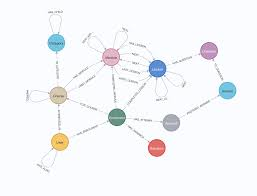](test)


In [10]:
username="neo4j"
password="qwer1234"
url="bolt://localhost:7687"
database="worknet-jobs"

In [11]:
from neo4j import GraphDatabase


with  GraphDatabase.driver(uri=url, auth=(username, password)) as driver:
    driver.verify_connectivity()
    session = driver.session(database=database)

In [13]:
csv_file_name = "pre_processed_jobs_worknet.csv"

session.run(f"""
LOAD CSV WITH HEADERS FROM 'file:///{csv_file_name}' AS row
WITH row.JobTitle as title
RETURN title
LIMIT 3
""").to_df()

,title
0,단순 포장반직원 모집합니다
1,단순포장 및 락크작업
2,육류 가공 식당납품


In [14]:
import pandas as pd

df = pd.read_csv("data/pre_processed_jobs_worknet.csv")
df.keys()

Index(['JobTitle', 'JobVolunteerExperience', 'RequiredExperienceMonths',
       'PreferredExperienceMonths', 'JobVolunteerEducation', 'WeeklyWorkdays',
       'Workdays', 'JobPayment', 'MinMonthlyPayment', 'MaxMonthlyPayment',
       'JobContractType', 'JobBenefits', 'CompanyName', 'CompanyIndustry',
       'CompanySize', 'CompanyLocation'],
      dtype='object')

In [49]:
print(df['CompanyIndustry'].count())
print(len(df['CompanyIndustry'].unique().tolist()))

896
333


In [ ]:

df['CompanyIndustry'].unique().tolist()

In [ ]:
query = """
LOAD CSV WITH HEADERS FROM 'file:///{csv_file_name}' AS row
WITH row
MERGE (j:Job {name: trim(row.JobTitle)})
    SET j.required_experience_months = COALESCE(toInteger(row.RequiredExperienceMonths), null)
    SET j.preferred_experience_months = COALESCE(toInteger(row.PreferredExperienceMonths), null)
    SET j.payment = trim(row.JobPayment)
    SET j.min_monthly_payment = COALESCE(toInteger(row.MinMonthlyPayment), null)
    SET j.max_monthly_payment = COALESCE(toInteger(row.MaxMonthlyPayment), null)
    
WITH row, j
WHERE row.Workdays IS NOT NULL
MERGE (wd:WeeklyWorkdays {value: toInteger(row.Workdays)})
MERGE (j)-[:HAS_WEEKLY_WORKDAYS]->(wd)

WITH row, j
WHERE row.JobContractType IS NOT NULL
MERGE (ct:ContractType {name: trim(row.JobContractType)})
MERGE (j)-[:USES_CONTRACT_TYPE]->(ct)

WITH row, j
WHERE row.JobVolunteerEducation IS NOT NULL
MERGE (ve:VolunteerEducation {name: trim(row.JobVolunteerEducation)})
MERGE (j)-[:REQUIRES_VOLUNTEER_EDUCATION]->(ve)

WITH row, j
WHERE row.JobBenefits IS NOT NULL
FOREACH (
    item in split(row.JobBenefits, ' ') | 
    MERGE (b:Benefit {name: trim(item)})
    MERGE (j)-[:PROVIDES_BENEFIT]->(b
)

// Company
WITH row, j
WHERE row.CompanyName IS NOT NULL
MERGE (c: Company {name: trim(row.CompanyName)})
	SET c.industry = COALESCE(trim(row.CompanyIndustry), null)
	SET c.size = COALESCE(trim(row.CompanySize), null)
    SET c.address = COALESCE(trim(row.CompanyLocation), null)
MERGE (c)-[:HAS_JOB_OPENING]->(j)
"""

result = session.run(query)